In [2]:
import lmfit
import numpy as np
import matplotlib.pyplot as plt

## LC circuit

In [7]:
def Z_LC_im(w,L,C):
    return -1*w*L/(w**2*L*C-1)

In [8]:
L = 1e-9 # H
C = 1e-12 # F
w0 = 1/(C*L)**0.5

w = np.linspace(0,2*w0,1000)

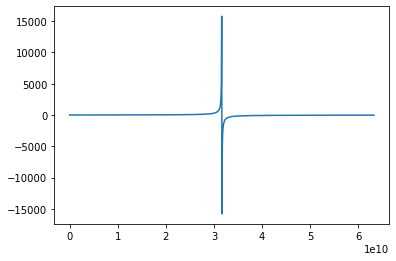

In [9]:
plt.plot(w,Z_LC_im(w,L,C))

In [6]:
Z_data = Z_LC_im(w,L,C)

How to fit this with LMfit? Complex data needs a bit more familiarity with lmfit, for now, let's test it with just the imaginary impedance data. 

Follow getting started:

https://lmfit.github.io/lmfit-py/intro.html

But we will use LMfit and not scipy because eventually we do want to fit complex valued Z.

From the LMfit intro: 

https://lmfit.github.io/lmfit-py/intro.html

In [13]:
from lmfit import minimize, Parameters

# generate synthetic data with noise
x = np.linspace(0, 100)
noise = np.random.normal(size=x.size, scale=0.2)
data = 7.5 * sin(x*0.22 + 2.5) * exp(-x*x*0.01) + noise

def residual(params, x, data, uncertainty):
    amp = params['amp']
    phaseshift = params['phase']
    freq = params['frequency']
    decay = params['decay']

    model = amp * sin(x*freq + phaseshift) * exp(-x*x*decay)

    return (data-model) / uncertainty

# generate experimental uncertainties
uncertainty = abs(0.16 + np.random.normal(size=x.size, scale=0.05))

params = Parameters()
params.add('amp', value=10)
params.add('decay', value=0.007)
params.add('phase', value=0.2)
params.add('frequency', value=3.0)

out = minimize(residual, params, args=(x, data, uncertainty))

OK, example from webpage runs with no errors. 

But, we do not have uncertainties: we want to make the assumption that all points have the same uncertainty. Can I just leave out uncertainty from the function? Answer is yes!

In [15]:
from lmfit import minimize, Parameters

# generate synthetic data with noise
x = np.linspace(0, 100)
noise = np.random.normal(size=x.size, scale=0.2)
data = 7.5 * sin(x*0.22 + 2.5) * exp(-x*x*0.01) + noise

def residual(params, x, data):
    amp = params['amp']
    phaseshift = params['phase']
    freq = params['frequency']
    decay = params['decay']

    model = amp * sin(x*freq + phaseshift) * exp(-x*x*decay)

    return (data-model) / uncertainty

params = Parameters()
params.add('amp', value=10)
params.add('decay', value=0.007)
params.add('phase', value=0.2)
params.add('frequency', value=3.0)

out = minimize(residual, params, args=(x, data))

In [19]:
out

Let's adapt it for the function above. 

In [17]:
# The function we want to fit
def Z_LC_im(w,L,C):
    return -1*w*L/(w**2*L*C-1)

# The "truth" values
L = 1e-9 # H
C = 1e-12 # F
w0 = 1/(C*L)**0.5
Z_data = Z_LC_im(w,L,C)

# The function used for residual calculation
def residual(params, w, data):
    amp = params['L']
    phaseshift = params['C']
    model = Z_LC_im(w,L,C)
    return (data-model)

# Initial guesses
params = Parameters()
params.add('L', value=L*1.1)
params.add('C', value=C*1.1)

fit_result = minimize(residual, params, args=(w, Z_data))

In [18]:
fit_result

It has *totally* not converged.

Maybe chi-square is too small numerically. It 1e-247. We maybe need to scale our data. Let's check.

I'm getting too lazy to figure this out. I will instead maybe just try scipy optimise.

## Scipy optimise

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

In [27]:
from scipy.optimize import minimize 

# The function we want to fit
def Z_LC_im(w,L,C):
    return -1*w*L/(w**2*L*C-1)

# The "truth" values
L = 1e-9 # H
C = 1e-12 # F
w0 = 1/(C*L)**0.5
Z_data = Z_LC_im(w,L,C)
w = np.linspace(0,2*w0,1000)

def cost_function(x):
    return np.sum(np.abs(Z_LC_im(w,x[0], x[1])-Z_data)**2)

x0 = [L*1.1,C*1.1]
res = minimize(cost_function,x0, method='Powell')

In [28]:
res

   direc: array([[0.00000000e+00, 1.00000000e+00],
       [1.71341737e+06, 2.92891621e+00]])
     fun: 615313724.2573438
 message: 'Optimization terminated successfully.'
    nfev: 124
     nit: 2
  status: 0
 success: True
       x: array([3.53595819e+06, 6.33616415e+00])

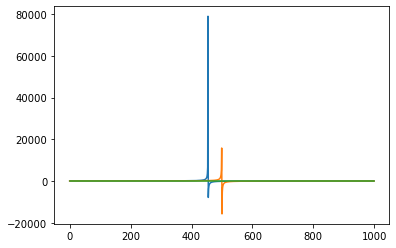

In [26]:
plt.plot(Z_LC_im(w,x0[0], x0[1]))
plt.plot(Z_data)
plt.plot(Z_LC_im(w,x[0],x[1]))

This was not a 30 second solution. 

Try curve_fit? 

# Try curve fit

In [30]:
from scipy.optimize import curve_fit 

# The function we want to fit
def Z_LC_im(w,L,C):
    return -1*w*L/(w**2*L*C-1)

# The "truth" values
L = 1e-9 # H
C = 1e-12 # F
w0 = 1/(C*L)**0.5
Z_data = Z_LC_im(w,L,C)
w = np.linspace(0,2*w0,1000)

initial_guess = [L*1.1,C*1.1]

values, covariances = curve_fit(Z_LC_im, w, Z_data, p0 = initial_guess)

In [31]:
values

array([-4.26541426e-10, -2.12011464e-13])

Total nonsense...

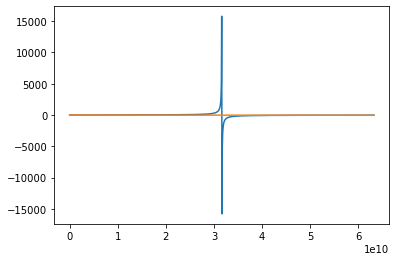

In [33]:
plt.plot(w, Z_data)
plt.plot(w, Z_LC_im(w,values[0], values[1]))

This is apparently a bit tricker than we thought. 